# Pandas 处理缺失值

## 用于表达“缺失”的值

对于不同的数据类型，pandas 使用不同的特定值来标识缺失数据。
`numpy.nan` 用于 NumPy 数据类型。使用 NumPy 数据类型的缺点是原始数据类型会被强制转换为 `np.float64` 或 `object` 。

In [1]:
import pandas as pd
import numpy as np
import pyarrow as pa

In [2]:
pd.Series([1, 2], dtype=np.int64).reindex([0, 1, 2])

0    1.0
1    2.0
2    NaN
dtype: float64

In [3]:
pd.Series([True, False], dtype=np.bool_).reindex([0, 1, 2])

0     True
1    False
2      NaN
dtype: object

`NaT` 对应于 NumPy 的 `np.datetime64` 、 `np.timedelta64` 和 `PeriodDtype` 。对于 Type 应用程序，使用 `api.types.NaTType` 。

In [4]:
pd.Series([1, 2], dtype=np.dtype("timedelta64[ns]")).reindex([0, 1, 2])

0   0 days 00:00:00.000000001
1   0 days 00:00:00.000000002
2                         NaT
dtype: timedelta64[ns]

In [5]:
pd.Series([1, 2], dtype=np.dtype("datetime64[ns]")).reindex([0, 1, 2])

0   1970-01-01 00:00:00.000000001
1   1970-01-01 00:00:00.000000002
2                             NaT
dtype: datetime64[ns]

In [6]:
pd.Series(["2020", "2020"], dtype=pd.PeriodDtype("D")).reindex([0, 1, 2])

0    2020-01-01
1    2020-01-01
2           NaT
dtype: period[D]

`NA` 对应于 `StringDtype` 、`Int64Dtype` （和其他位宽）、 `Float64Dtype` （和其他位宽）、 ：class:`BooleanDtype` 和 `ArrowDtype` 。这些类型将保持数据的原始数据类型。对于 Type 应用程序，使用 `api.types.NAType` 。

In [7]:
pd.Series([1, 2], dtype="Int64").reindex([0, 1, 2])

0       1
1       2
2    <NA>
dtype: Int64

In [8]:
pd.Series([True, False], dtype="boolean[pyarrow]").reindex([0, 1, 2])

0     True
1    False
2     <NA>
dtype: bool[pyarrow]

要检测这些缺失值，请使用 `isna()` 或 `notna()` 方法。

In [9]:
ser = pd.Series([pd.Timestamp("2020-01-01"), pd.NaT])
ser

0   2020-01-01
1          NaT
dtype: datetime64[ns]

In [10]:
pd.isna(ser)

0    False
1     True
dtype: bool

`isna()` 或 `notna()` 也会将 None 视为缺失值。

In [11]:
ser = pd.Series([1, None], dtype=object)
ser

0       1
1    None
dtype: object

In [12]:
pd.isna(ser)

0    False
1     True
dtype: bool

`np.nan` 、`NaT` 和 `NA` 之间的相等运算与 `None` **不同**

In [13]:
None == None

True

In [14]:
np.nan == np.nan

False

In [15]:
pd.NaT == pd.NaT

False

In [16]:
pd.NA == pd.NA

<NA>

因此，具有这些缺失值之一的 `DataFrame` 或 `Series` 之间的相等性比较结果与 `isna()` 或 `notna()` 不相。

In [17]:
ser = pd.Series([True, None], dtype="boolean[pyarrow]")
ser == pd.NA

0    <NA>
1    <NA>
dtype: boolean

In [18]:
pd.isna(ser)

0    False
1     True
dtype: bool

## NA 语义

警告：

实验性的：`NA` 的行为仍然可以在没有警告的情况下发生变化。

从 pandas 1.0 开始，可以使用实验性 `NA` 值（单例）来表示标量缺失值。`NA` 的目标是提供一个“缺失”指示符，该指示符可以跨数据类型一致地使用（而不是 `np.nan` 、 `None` 或 `pd.NaT` 取决于数据类型）。

例如，当 Series 中具有可为 null 的整数 dtype 时，它将使用 `NA` ：

In [19]:
s = pd.Series([1, 2, None], dtype="Int64")

In [20]:
s[2]

<NA>

In [21]:
s[2] is pd.NA

True

目前，pandas 尚未在 `DataFrame` 或 `Series` 中默认使用使用 `NA` ，因此您需要显式指定 dtype。转换为这些 dtypes 的一种简单方法在官方文档的 conversion 部分进行了说明。

### 算术和比较运算中的传播

通常，缺失值（包括 `NA` ）会在操作中传播。当其中一个操作数未知时，操作的结果也是未知的。

例如，NA 在算术运算中传播，类似于 np.nan：

In [22]:
pd.NA + 1

<NA>

In [23]:
"a" * pd.NA

<NA>

在一些特殊情况下，结果是已知的，即使其中一个作数是 `NA` 也是如此。

In [24]:
pd.NA == 1

<NA>

In [25]:
pd.NA == pd.NA

<NA>

In [26]:
pd.NA < 2.5

<NA>

要检查值是否等于 `NA` ，请使用 `isna()` 。

In [27]:
pd.isna(pd.NA)

True

注意

此基本传播规则的一个例外是减少 （例如平均值或最小值），其中 pandas 默认跳过缺失值。有关更多信息，请参阅官方文档的计算部分。

### 逻辑运算

对于逻辑运算，`NA` 遵循三值逻辑（或 Kleene 逻辑，类似于 R、SQL 和 Julia）的规则。此逻辑意味着仅在逻辑需要时传播缺失值。

例如，对于逻辑 “or” 运算 （ `|` ），如果其中一个操作数为 `True` ，则我们已经知道结果将为 `True` ，而不管其他值如何（因此，无论缺失值是 `True` 还是 `False`）。在这种情况下，`NA` 不会传播：

In [28]:
True | False

True

In [29]:
True | pd.NA

True

In [30]:
pd.NA | True

True

另一方面，如果其中一个操作数为 `False` ，则结果取决于另一个操作数的值。因此，在这种情况下，`NA` 会传播：

In [31]:
False | True

True

In [32]:
False | False

False

In [33]:
False | pd.NA

<NA>

逻辑 “and” 操作（ `&` ）的行为可以使用类似的逻辑推导出来（现在如果其中一个操作数已经是 `False` ，则 `NA` 将不会传播）：

In [34]:
False & True

False

In [35]:
False & False

False

In [36]:
False & pd.NA

False

In [37]:
True & True

True

In [38]:
True & False

False

In [39]:
True & pd.NA

<NA>

### 布尔上下文中的 NA

由于 NA 的实际值是未知的，因此将 NA 转换为布尔值是模棱两可的。

In [40]:
bool(pd.NA)

TypeError: boolean value of NA is ambiguous

这也意味着 `NA` 不能在计算为布尔值的上下文中使用，例如 `if condition： ...` 其中 `condition` 可以是 `NA` 。在这种情况下，`isna（）` 可用于检查 `NA` 或可以避免 `NA` 的条件，例如通过预先填充缺失值。

在 `if` 语句中使用 `Series` 或 `DataFrame` 对象时，会出现类似的情况，请参阅将 `if/truth` 语句与 `pandas` 结合使用。

### NumPy ufuncs

`pandas.NA` 实现了 `NumPy` 的 `__array_ufunc__` 协议。大多数 `ufuncs` 都可以使用 `NA` ，并且通常返回 `NA` ：

In [41]:
np.log(pd.NA)

<NA>

In [42]:
np.add(pd.NA, 1)

<NA>

警告

目前，涉及 `ndarray` 和 `NA` 的 `ufunc` 将返回一个填充了 `NA` 值的 `object-dtype` 。

In [43]:
a = np.array([1, 2, 3])
np.greater(a, pd.NA)

array([<NA>, <NA>, <NA>], dtype=object)

此处的返回类型将来可能会更改为返回不同的数组类型。

有关 ufunc 的更多信息，请参阅官方文档 DataFrame 与 NumPy 函数的互作性。

#### 转换

如果你有一个使用 `np.nan` 的 `DataFrame` 或 `Series` ，那么 `DataFrame` 中的 `Series.convertdtypes()` 和 `DataFrame.convertdtypes()` 可以转换数据以使用使用 `NA` 的数据类型，例如 `Int64Dtype` 或 `ArrowDtype` 。在从推断数据类型的 IO 方法中读取数据集后，这尤其有用。

在此示例中，虽然所有列的 dtypes 都已更改，但我们显示前 10 列的结果。

In [44]:
import io

In [45]:
data = io.StringIO("a,b\n,True\n2,")
df = pd.read_csv(data)
df

,a,b
0,NaN,True
1,2.0,NaN


In [46]:
df.dtypes

a    float64
b     object
dtype: object

In [47]:
df_conv = df.convert_dtypes()
df_conv

,a,b
0,<NA>,True
1,2,<NA>


In [48]:
df_conv.dtypes

a      Int64
b    boolean
dtype: object

### 插入缺失数据

只需赋值给 Series 或 DataFrame 即可插入缺失值，缺失值的哨兵值将由 dtype 决定。

In [49]:
ser = pd.Series([1., 2., 3.])
ser.loc[0] = None
ser

0    NaN
1    2.0
2    3.0
dtype: float64

In [50]:
ser = pd.Series([pd.Timestamp("2021"), pd.Timestamp("2021")])
ser.iloc[0] = np.nan
ser

0          NaT
1   2021-01-01
dtype: datetime64[ns]

In [51]:
ser = pd.Series([True, False], dtype="boolean[pyarrow]")
ser.iloc[0] = None
ser

0     <NA>
1    False
dtype: bool[pyarrow]

对于 object 类型， pandas 将使用原值：

In [52]:
s = pd.Series(["a", "b", "c"], dtype=object)
s.loc[0] = None
s.loc[1] = np.nan
s

0    None
1     NaN
2       c
dtype: object

### 缺失值的计算

缺失值通过 pandas 对象之间的算术运算传播。

In [53]:
ser1 = pd.Series([np.nan, np.nan, 2, 3])
ser2 = pd.Series([np.nan, 1, np.nan, 4])
ser1

0    NaN
1    NaN
2    2.0
3    3.0
dtype: float64

In [54]:
ser2

0    NaN
1    1.0
2    NaN
3    4.0
dtype: float64

In [55]:
ser1 + ser2

0    NaN
1    NaN
2    NaN
3    7.0
dtype: float64

数据结构概述中讨论的描述性统计和计算方法都是对缺失数据的解释。

对数据求和时，NA 值或空数据将被视为零。

In [56]:
pd.Series([np.nan]).sum()

0.0

In [57]:
pd.Series([], dtype="float64").sum()

0.0

取乘积时，NA 值或空数据将被视为 1。

In [58]:
pd.Series([np.nan]).prod()

1.0

In [59]:
pd.Series([], dtype="float64").prod()

1.0

像 cumsum() 和 cumprod() 这样的累积方法默认情况下会忽略 NA 值，并在结果中保留它们。此行为可以使用 skipna 进行更改

* 像 cumsum() 和 cumprod() 这样的累积方法默认情况下会忽略 NA 值，但在结果数组中保留它们。要覆盖此行为并包含 NA 值，请使用 skipna=False。


In [60]:
ser = pd.Series([1, np.nan, 3, np.nan])
ser

0    1.0
1    NaN
2    3.0
3    NaN
dtype: float64

In [61]:
ser.cumsum()

0    1.0
1    NaN
2    4.0
3    NaN
dtype: float64

In [62]:
ser.cumsum(skipna=False)

0    1.0
1    NaN
2    NaN
3    NaN
dtype: float64

### 删除缺失数据

dropna() 删除包含缺失数据的行或列。

In [63]:
df = pd.DataFrame([[np.nan, 1, 2], [1, 2, np.nan], [1, 2, 3]])
df

,0,1,2
0,NaN,1,2.0
1,1.0,2,NaN
2,1.0,2,3.0


In [64]:
df.dropna()

,0,1,2
2,1.0,2,3.0


In [65]:
df.dropna(axis=1)

,1
0,1
1,2
2,2


In [66]:
ser = pd.Series([1, pd.NA], dtype="int64[pyarrow]")
ser.dropna()

0   1
dtype: int64[pyarrow]

### 填充缺失数据

#### 按值填充

fillna() 用非 NA 数据替换 NA 值。

用标量值替换 NA

In [67]:
data = {"np": [1.0, np.nan, np.nan, 2], "arrow": pd.array([1.0, pd.NA, pd.NA, 2], dtype="float64[pyarrow]")}
df = pd.DataFrame(data)
df

,np,arrow
0,1.0,1.0
1,NaN,<NA>
2,NaN,<NA>
3,2.0,2.0


In [68]:
df.fillna(0)

,np,arrow
0,1.0,1.0
1,0.0,0.0
2,0.0,0.0
3,2.0,2.0


向前或向后填充间隙

In [69]:
df.ffill()

,np,arrow
0,1.0,1.0
1,1.0,1.0
2,1.0,1.0
3,2.0,2.0


In [70]:
df.bfill()

,np,arrow
0,1.0,1.0
1,2.0,2.0
2,2.0,2.0
3,2.0,2.0


限制填充的 NA 值的数量

In [71]:
df.ffill(limit=1)

,np,arrow
0,1.0,1.0
1,1.0,1.0
2,NaN,<NA>
3,2.0,2.0


NA 值可以用来自 Series 或 DataFrame 的对应值替换，其中原始对象和填充对象之间的索引和列对齐。

In [72]:
dff = pd.DataFrame(np.arange(30, dtype=np.float64).reshape(10, 3), columns=list("ABC"))
dff.iloc[3:5, 0] = np.nan
dff.iloc[4:6, 1] = np.nan
dff.iloc[5:8, 2] = np.nan
dff

,A,B,C
0,0.0,1.0,2.0
1,3.0,4.0,5.0
2,6.0,7.0,8.0
3,NaN,10.0,11.0
4,NaN,NaN,14.0
5,15.0,NaN,NaN
6,18.0,19.0,NaN
7,21.0,22.0,NaN
8,24.0,25.0,26.0
9,27.0,28.0,29.0


In [73]:
dff.fillna(dff.mean())

,A,B,C
0,0.00,1.0,2.000000
1,3.00,4.0,5.000000
2,6.00,7.0,8.000000
3,14.25,10.0,11.000000
4,14.25,14.5,14.000000
5,15.00,14.5,13.571429
6,18.00,19.0,13.571429
7,21.00,22.0,13.571429
8,24.00,25.0,26.000000
9,27.00,28.0,29.000000


注意

DataFrame.where() 也可以用来填充 NA 值。与上面相同的结果。

In [74]:
dff.where(pd.notna(dff), dff.mean(), axis="columns")

,A,B,C
0,0.00,1.0,2.000000
1,3.00,4.0,5.000000
2,6.00,7.0,8.000000
3,14.25,10.0,11.000000
4,14.25,14.5,14.000000
5,15.00,14.5,13.571429
6,18.00,19.0,13.571429
7,21.00,22.0,13.571429
8,24.00,25.0,26.000000
9,27.00,28.0,29.000000


#### 插值

DataFrame.interpolate() 和 Series.interpolate() 使用多种插值方法填充 NA 值。

In [75]:
df = pd.DataFrame(
    {
        "A": [1, 2.1, np.nan, 4.7, 5.6, 6.8],
        "B": [0.25, np.nan, np.nan, 4, 12.2, 14.4],
    }
)
df

,A,B
0,1.0,0.25
1,2.1,NaN
2,NaN,NaN
3,4.7,4.00
4,5.6,12.20
5,6.8,14.40


In [76]:
df.interpolate()

,A,B
0,1.0,0.25
1,2.1,1.50
2,3.4,2.75
3,4.7,4.00
4,5.6,12.20
5,6.8,14.40


In [77]:
idx = pd.date_range("2020-01-01", periods=10, freq="D")
data = np.random.default_rng(2).integers(0, 10, 10).astype(np.float64)
ts = pd.Series(data, index=idx)
ts.iloc[[1, 2, 5, 6, 9]] = np.nan
ts

2020-01-01    8.0
2020-01-02    NaN
2020-01-03    NaN
2020-01-04    2.0
2020-01-05    4.0
2020-01-06    NaN
2020-01-07    NaN
2020-01-08    0.0
2020-01-09    3.0
2020-01-10    NaN
Freq: D, dtype: float64

<Axes: >

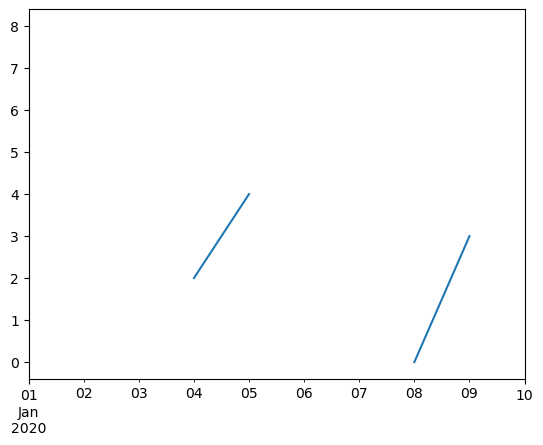

In [78]:
ts.plot()

In [79]:
ts.interpolate()

2020-01-01    8.000000
2020-01-02    6.000000
2020-01-03    4.000000
2020-01-04    2.000000
2020-01-05    4.000000
2020-01-06    2.666667
2020-01-07    1.333333
2020-01-08    0.000000
2020-01-09    3.000000
2020-01-10    3.000000
Freq: D, dtype: float64

<Axes: >

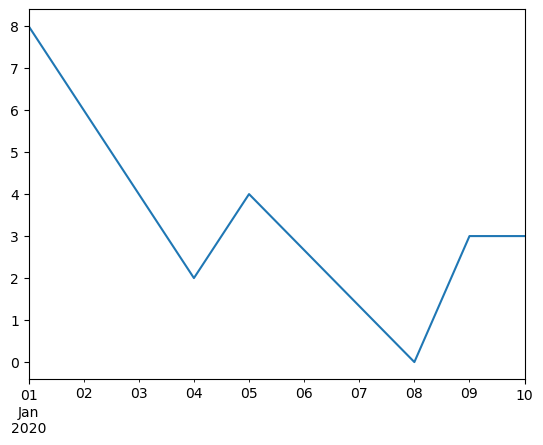

In [80]:
ts.interpolate().plot()

在 DatetimeIndex 中相对于 Timestamp 的插值可以通过设置 method="time" 来实现。

In [81]:
ts2 = ts.iloc[[0, 1, 3, 7, 9]]

ts2

2020-01-01    8.0
2020-01-02    NaN
2020-01-04    2.0
2020-01-08    0.0
2020-01-10    NaN
dtype: float64

In [82]:
ts2.interpolate()

2020-01-01    8.0
2020-01-02    5.0
2020-01-04    2.0
2020-01-08    0.0
2020-01-10    0.0
dtype: float64

In [83]:
ts2.interpolate(method="time")

2020-01-01    8.0
2020-01-02    6.0
2020-01-04    2.0
2020-01-08    0.0
2020-01-10    0.0
dtype: float64

对于浮点数索引，使用 method='values'。

In [84]:
idx = [0.0, 1.0, 10.0]
ser = pd.Series([0.0, np.nan, 10.0], idx)
ser

0.0      0.0
1.0      NaN
10.0    10.0
dtype: float64

In [85]:
ser.interpolate()

0.0      0.0
1.0      5.0
10.0    10.0
dtype: float64

In [86]:
ser.interpolate(method="values")

0.0      0.0
1.0      1.0
10.0    10.0
dtype: float64

如果您安装了 scipy，您可以将一维插值例程的名称传递给 method，如 scipy 插值 文档 和参考 指南 中所述。合适的插值方法将取决于数据类型。

提示

如果您处理的是以越来越快的速度增长的时序数据，请使用 method='barycentric'。

如果您有近似累积分布函数的值，请使用 method='pchip'。

要使用平滑绘图填充缺失值，请使用 method='akima'。

In [87]:
df = pd.DataFrame(
   {
      "A": [1, 2.1, np.nan, 4.7, 5.6, 6.8],
      "B": [0.25, np.nan, np.nan, 4, 12.2, 14.4],
   }
)
df

,A,B
0,1.0,0.25
1,2.1,NaN
2,NaN,NaN
3,4.7,4.00
4,5.6,12.20
5,6.8,14.40


In [88]:
df.interpolate(method="barycentric")

,A,B
0,1.00,0.250
1,2.10,-7.660
2,3.53,-4.515
3,4.70,4.000
4,5.60,12.200
5,6.80,14.400


In [89]:
df.interpolate(method="pchip")

,A,B
0,1.00000,0.250000
1,2.10000,0.672808
2,3.43454,1.928950
3,4.70000,4.000000
4,5.60000,12.200000
5,6.80000,14.400000


In [90]:
df.interpolate(method="akima")

,A,B
0,1.000000,0.250000
1,2.100000,-0.873316
2,3.406667,0.320034
3,4.700000,4.000000
4,5.600000,12.200000
5,6.800000,14.400000


当通过多项式或样条逼近进行插值时，您还必须指定逼近的次数或阶数。

In [91]:
df.interpolate(method="spline", order=2)

,A,B
0,1.000000,0.250000
1,2.100000,-0.428598
2,3.404545,1.206900
3,4.700000,4.000000
4,5.600000,12.200000
5,6.800000,14.400000


In [92]:
df.interpolate(method="polynomial", order=2)

,A,B
0,1.000000,0.250000
1,2.100000,-2.703846
2,3.451351,-1.453846
3,4.700000,4.000000
4,5.600000,12.200000
5,6.800000,14.400000


比较几种方法。

<Axes: >

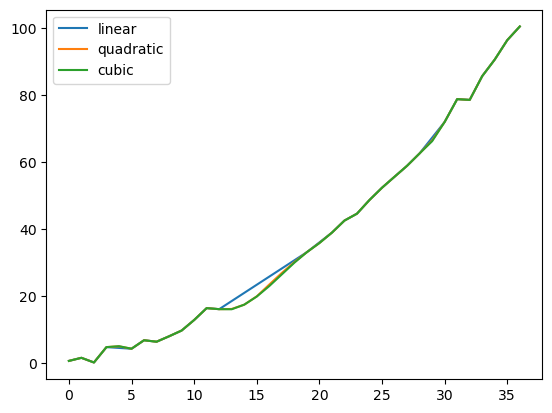

In [93]:
np.random.seed(2)
ser = pd.Series(np.arange(1, 10.1, 0.25) ** 2 + np.random.randn(37))
missing = np.array([4, 13, 14, 15, 16, 17, 18, 20, 29])
ser.iloc[missing] = np.nan
methods = ["linear", "quadratic", "cubic"]
df = pd.DataFrame({m: ser.interpolate(method=m) for m in methods})
df.plot()

使用 Series.reindex() 从扩展数据中插值新的观测值。

In [94]:
ser = pd.Series(np.sort(np.random.uniform(size=100)))

# interpolate at new_index

new_index = ser.index.union(pd.Index([49.25, 49.5, 49.75, 50.25, 50.5, 50.75]))

interp_s = ser.reindex(new_index).interpolate(method="pchip")

interp_s.loc[49:51]

49.00    0.471410
49.25    0.476841
49.50    0.481780
49.75    0.485998
50.00    0.489266
50.25    0.491814
50.50    0.493995
50.75    0.495763
51.00    0.497074
dtype: float64

##### 插值限制

interpolate() 接受一个 limit 关键字参数，以限制自上次有效观测值以来填充的连续 NaN 值的数量。

In [95]:
ser = pd.Series([np.nan, np.nan, 5, np.nan, np.nan, np.nan, 13, np.nan, np.nan])
ser

0     NaN
1     NaN
2     5.0
3     NaN
4     NaN
5     NaN
6    13.0
7     NaN
8     NaN
dtype: float64

In [96]:
ser.interpolate()

0     NaN
1     NaN
2     5.0
3     7.0
4     9.0
5    11.0
6    13.0
7    13.0
8    13.0
dtype: float64

In [97]:
ser.interpolate(limit=1)

0     NaN
1     NaN
2     5.0
3     7.0
4     NaN
5     NaN
6    13.0
7    13.0
8     NaN
dtype: float64

默认情况下，NaN 值将按 forward 方向填充。使用 limit_direction 参数从 backward 方向或 both 方向填充。

In [98]:
ser.interpolate(limit=1, limit_direction="backward")

0     NaN
1     5.0
2     5.0
3     NaN
4     NaN
5    11.0
6    13.0
7     NaN
8     NaN
dtype: float64

In [99]:
ser.interpolate(limit=1, limit_direction="both")

0     NaN
1     5.0
2     5.0
3     7.0
4     NaN
5    11.0
6    13.0
7    13.0
8     NaN
dtype: float64

In [100]:
ser.interpolate(limit_direction="both")

0     5.0
1     5.0
2     5.0
3     7.0
4     9.0
5    11.0
6    13.0
7    13.0
8    13.0
dtype: float64

默认情况下，无论NaN值是否被现有有效值包围或位于现有有效值之外，都会填充这些值。 limit_area参数将填充限制在值内部或外部。

In [101]:
# fill one consecutive inside value in both directions

ser.interpolate(limit_direction="both", limit_area="inside", limit=1)

0     NaN
1     NaN
2     5.0
3     7.0
4     NaN
5    11.0
6    13.0
7     NaN
8     NaN
dtype: float64

In [102]:
# fill all consecutive outside values backward

ser.interpolate(limit_direction="backward", limit_area="outside")

0     5.0
1     5.0
2     5.0
3     NaN
4     NaN
5     NaN
6    13.0
7     NaN
8     NaN
dtype: float64

In [103]:
# fill all consecutive outside values in both directions

ser.interpolate(limit_direction="both", limit_area="outside")


0     5.0
1     5.0
2     5.0
3     NaN
4     NaN
5     NaN
6    13.0
7    13.0
8    13.0
dtype: float64

#### 替换值
Series.replace() 和 DataFrame.replace() 可以类似于 Series.fillna() 和 DataFrame.fillna() 来替换或插入缺失值。

In [104]:
df = pd.DataFrame(np.eye(3))
df

,0,1,2
0,1.0,0.0,0.0
1,0.0,1.0,0.0
2,0.0,0.0,1.0


In [105]:
df_missing = df.replace(0, np.nan)
df_missing

,0,1,2
0,1.0,NaN,NaN
1,NaN,1.0,NaN
2,NaN,NaN,1.0


In [106]:
df_filled = df_missing.replace(np.nan, 2)
df_filled

,0,1,2
0,1.0,2.0,2.0
1,2.0,1.0,2.0
2,2.0,2.0,1.0


通过传递列表可以替换多个值。

In [107]:
df_filled.replace([1, 2], [11, 22])

,0,1,2
0,11.0,22.0,22.0
1,22.0,11.0,22.0
2,22.0,22.0,11.0


使用映射字典进行替换。

In [108]:
df_filled.replace({1: 44, 2: 28})

,0,1,2
0,44.0,28.0,28.0
1,28.0,44.0,28.0
2,28.0,28.0,44.0


##### 正则表达式替换

注意

以r字符为前缀的 Python 字符串，例如 `r'hello world'` 是 “原始”字符串。它们在反斜杠方面的语义与没有此前缀的字符串不同。原始字符串中的反斜杠将被解释为转义的反斜杠，例如，`r'\' == '\\'`。


将 ‘.’ 替换为 NaN

In [109]:
d = {"a": list(range(4)), "b": list("ab.."), "c": ["a", "b", np.nan, "d"]}
df = pd.DataFrame(d)
df.replace(".", np.nan)

,a,b,c
0,0,a,a
1,1,b,b
2,2,NaN,NaN
3,3,NaN,d


使用正则表达式将 ‘.’ 替换为 NaN，该正则表达式会删除周围的空格

In [110]:
df.replace(r"\s*\.\s*", np.nan, regex=True)

,a,b,c
0,0,a,a
1,1,b,b
2,2,NaN,NaN
3,3,NaN,d


注意注意使用正则表达式列表进行替换。

In [111]:
df.replace([r"\.", r"(a)"], ["dot", r"\1stuff"], regex=True)

,a,b,c
0,0,astuff,astuff
1,1,b,b
2,2,dot,NaN
3,3,dot,d


使用映射字典中的正则表达式进行替换。

In [112]:
# 需要提供两个字典，第一个字典指示列名称和查找的对象，第二个字典指示列名称和替换的内容
df.replace({"b": r"\s*\.\s*", "c": r"(a)"}, {"b": np.nan, "c": "cat"}, regex=True)

,a,b,c
0,0,a,cat
1,1,b,b
2,2,NaN,NaN
3,3,NaN,d


传递使用 regex 关键字的嵌套正则表达式字典。

In [113]:
df.replace({"b": {"b": r""}}, regex=True)

,a,b,c
0,0,a,a
1,1,,b
2,2,.,NaN
3,3,.,d


In [114]:
df.replace(regex={"b": {r"\s*\.\s*": np.nan}})

,a,b,c
0,0,a,a
1,1,b,b
2,2,NaN,NaN
3,3,NaN,d


In [115]:
df.replace({"b": r"\s*(\.)\s*"}, {"b": r"\1ty"}, regex=True)

,a,b,c
0,0,a,a
1,1,b,b
2,2,.ty,NaN
3,3,.ty,d


In [116]:
df.replace([r"\s*\.\s*", r"a|b"], "placeholder", regex=True)

,a,b,c
0,0,placeholder,placeholder
1,1,placeholder,placeholder
2,2,placeholder,NaN
3,3,placeholder,d


所有正则表达式示例也可以通过 to_replace 参数作为 regex 参数传递。在这种情况下，必须通过名称显式传递 value 参数，或者 regex 必须是嵌套字典。

In [117]:
df.replace(regex=[r"\s*\.\s*", r"a|b"], value="placeholder")

,a,b,c
0,0,placeholder,placeholder
1,1,placeholder,placeholder
2,2,placeholder,NaN
3,3,placeholder,d


<div class="alert alert-info">
    <b> 注意 </b>
</div>

来自 `re.compile` 的正则表达式对象也是有效的输入。

## 参考资料
1. [官方文档 Working with missing data](https://pandas.pydata.org/pandas-docs/stable/user_guide/missing_data.html)